In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

# Utilities

In [3]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return image

def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))
  return content_image, style_image

def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0
  return image

# Download Images

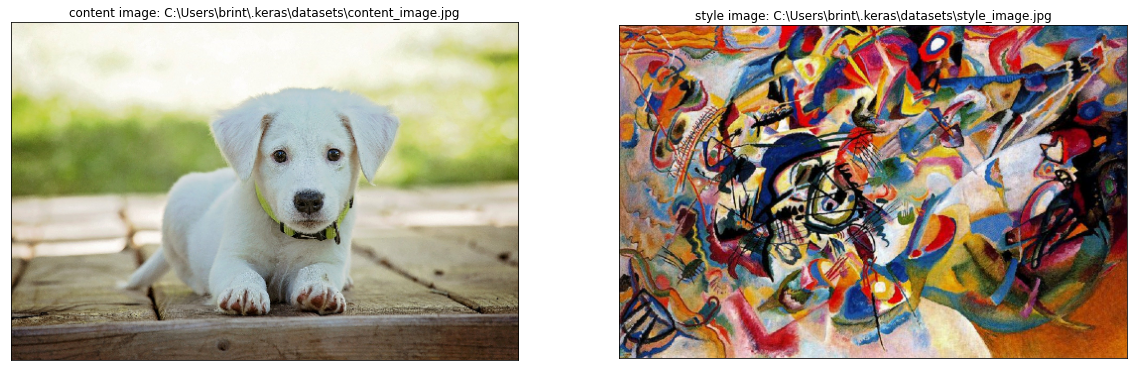

In [4]:
content_path = tf.keras.utils.get_file('content_image.jpg','https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg')
style_path = tf.keras.utils.get_file('style_image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Build Feature Extractor

In [6]:
content_layers = ['conv2d_88']

# choose the five style layers of interest
style_layers = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4']
# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers
# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [8]:
def inception_model(layer_names):
  # Load InceptionV3 with the imagenet weights and **without** the fully-connected layer at the top of the network
  inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False
  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(name).output for name in layer_names]
  # Create the model that outputs the content and style layers
  model = tf.keras.models.Model(inputs=inception.input, outputs=output_layers)
  # return the model
  return model

inception = inception_model(content_and_style_layers)

# Calculate Style Loss

In [9]:
def get_style_loss(features, targets):
  style_loss = tf.reduce_mean(tf.square(features-targets))
  return style_loss

# Calculate Content Loss

In [10]:
def get_content_loss(features, targets):
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
  return content_loss

# Calculate Gram matrix

In [12]:
def gram_matrix(input_tensor):
  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations

  return scaled_gram

# Calculate Total Loss

In [14]:
def get_style_image_features(image):
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_output) for style_output in style_outputs]
  return gram_style_features

def get_content_image_features(image):
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]
  return content_outputs

In [16]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_weight * style_loss / NUM_STYLE_LAYERS

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_weight * content_loss / NUM_CONTENT_LAYERS

  # sum up the style and content losses
  total_loss = style_loss + content_loss
  return total_loss

# Calculate and Apply Gradients


In [18]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight):
  with tf.GradientTape() as tape:

    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features,
                                  content_targets, content_features,
                                  style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)
  return gradients

In [20]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):
  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, style_weight, content_weight)

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])
  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [22]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  images = []
  step = 0
  # get the style image features
  style_targets = get_style_image_features(style_image)

  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  # collect the image updates starting from the content image
  images.append(content_image)
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, style_weight,
                            content_weight, optimizer)

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)

    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))

  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

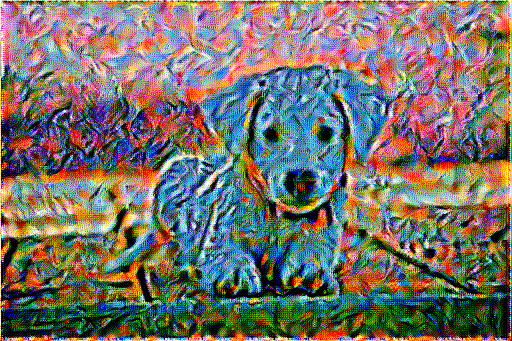

Train step: 400
..................................................................

In [23]:
# define style and content weight
style_weight =  1
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)